Jupyter notebook to generate the goal points using a previously filtered driveable area with only (in most cases) the plausibles lanes towards which the car can go

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# General purpose imports

import sys
import yaml
import time
import os
import git
import pdb
import copy

from prodict import Prodict

# DL & Math

import math
import pandas as pd
import numpy as np
import cv2

# Plot imports

import matplotlib.pyplot as plt

In [3]:
repo = git.Repo('.', search_parent_directories=True)
BASE_DIR = repo.working_tree_dir
sys.path.append(BASE_DIR)

import model.datasets.argoverse.dataset as dataset
import model.datasets.argoverse.dataset_utils as dataset_utils
import model.datasets.argoverse.goal_points_functions as goal_points_functions  
import model.datasets.argoverse.map_functions as map_functions                                            

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Folder

dataset_path = "data/datasets/argoverse/motion-forecasting/"
split = "val"
split_percentage = 0.01
split_folder = os.path.join(BASE_DIR,dataset_path,split)

goal_points_folder = os.path.join(split_folder,"goal_points_smart")
if not os.path.exists(goal_points_folder):
    print("Create output folder: ", goal_points_folder)
    os.makedirs(goal_points_folder) # makedirs creates intermediate folders

data_images_folder = os.path.join(split_folder,"map_features")

In [9]:
# Trajectory raw data

RAW_DATA_FORMAT = {
    "TIMESTAMP": 0,
    "TRACK_ID": 1,
    "OBJECT_TYPE": 2,
    "X": 3,
    "Y": 4,
    "CITY_NAME": 5,
}

# Goal points hyperparameters

show = True
save_fig = True
change_img_bg = False
rows = 400
NUM_CENTERLINES = 3
CENTERLINE_LENGTH = 30
# num_initial_samples = CENTERLINE_LENGTH * NUM_CENTERLINES
num_initial_samples = 256
pred_seconds = 3 # [seconds] To compute the goal points 
                 #           until pred_seconds ahead (assuming constant velocity)
NUM_GOAL_POINTS = 32
MAX_CLUSTERS = 6 # Maximum number of modes (multimodality)
MULTIMODAL = True 

pred_len = 30
obs_len = 20
obs_origin = 20

In [10]:
# 0. Load data dict with the relevant physical info for each sequence (regarding the target agent)

# npz_file = "relevant_centerlines_map_api_first_obs_40_points.npz"
npz_file = "relevant_centerlines_map_api_last_obs_30_points.npz"

npz_filename = os.path.join(split_folder,
                         f"data_processed_{str(int(split_percentage*100))}_percent",
                         npz_file)
relevant_centerlines = np.load(npz_filename,allow_pickle=True)
data_dict = relevant_centerlines['arr_0'].item()

data_dict['1'].keys()

dict_keys(['relevant_centerlines_filtered', 'center_plausible_area_filtered', 'real_world_width', 'real_world_height'])

rw width, rw height:  25.771889263633284 25.574825659091175
rows, cols:  400 404
scale_x, scale_y:  15.675994719179725 15.640380322898137
Center px:  (200, 202)


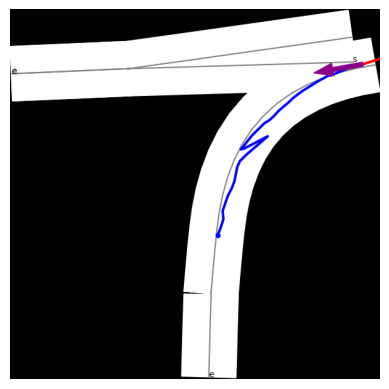

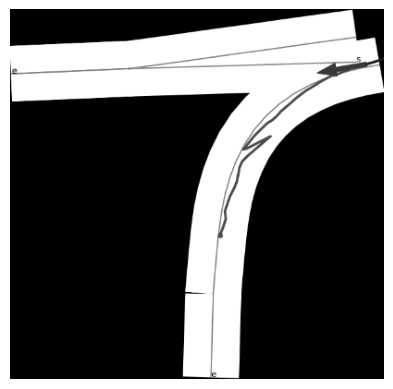

In [14]:
# 1. Load specific sequence info

file_id = 272

# 1.1. Load agent's trajectory

seq_path = os.path.join(split_folder,"data",str(file_id)+".csv")

df = pd.read_csv(seq_path, dtype={"TIMESTAMP": str})
agent_track = df[df["OBJECT_TYPE"] == "AGENT"].values
city_name = agent_track[0,RAW_DATA_FORMAT["CITY_NAME"]]
agent_xy = agent_track[:,[RAW_DATA_FORMAT["X"],RAW_DATA_FORMAT["Y"]]].astype("float")
last_obs = agent_xy[obs_origin-1,:]

# 1.2. Load plausible map info

img_filename = os.path.join(data_images_folder,str(file_id)+"_binary_plausible_area_filtered_color.png")

relevant_centerlines_filtered = data_dict[str(file_id)]["relevant_centerlines_filtered"]
center_plausible_area_filtered = data_dict[str(file_id)]["center_plausible_area_filtered"]
real_world_width = data_dict[str(file_id)]["real_world_width"]
real_world_height = data_dict[str(file_id)]["real_world_height"]

print("rw width, rw height: ", real_world_width, real_world_height)

# rows = height (y in rw) and cols = width (x in rw) of an image

## Rescale the columns in order to have roughly the same scale in both axis

cols = math.ceil(rows*(real_world_width/real_world_height)) 
scale_x = float(cols/real_world_width) # px/m
scale_y = float(rows/real_world_height) # px/m
center_px = (int(rows/2),int(cols/2))

print("rows, cols: ", rows, cols)
print("scale_x, scale_y: ", scale_x, scale_y)
print("Center px: ", center_px)

img = cv2.imread(img_filename)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img,cmap='gray')
plt.axis("off")
plt.show()

img = cv2.resize(img, dsize=(cols,rows))
img_gray = cv2.resize(img_gray, dsize=(cols,rows))

plt.imshow(img_gray,cmap='gray')
plt.axis("off")
plt.show()

img:  (400, 404, 3)


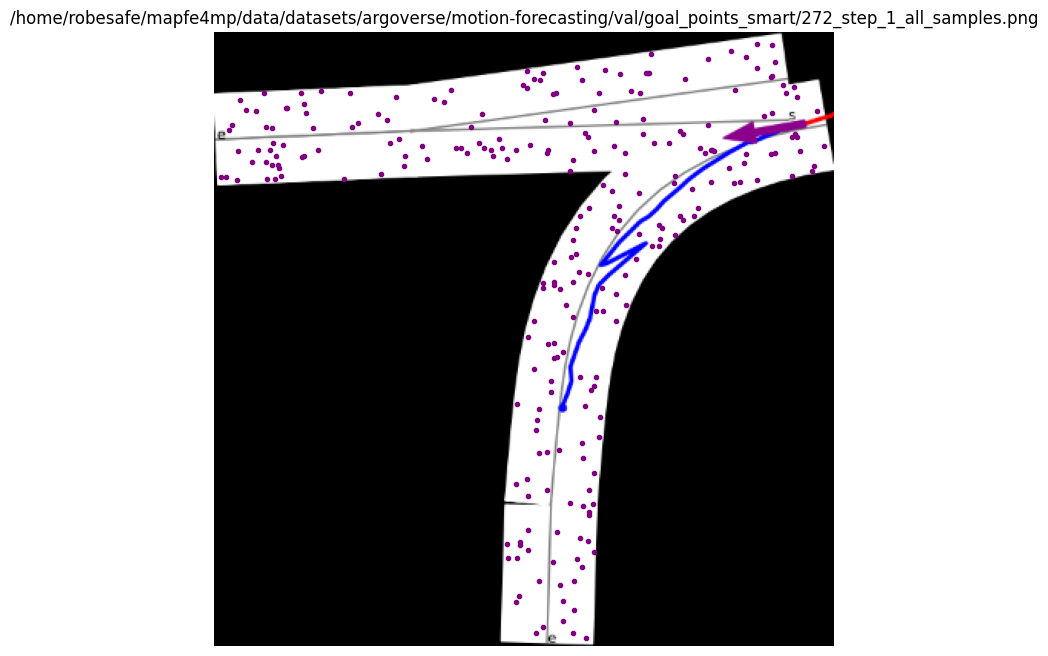

In [15]:
# 2. Get random points from the feasible area points (N samples)

rad = 1000 # meters. Cause we want to observe all points around the AGENT
rad_px = rad * scale_x # m * (px/m) = px (pixels)

fe_y, fe_x = goal_points_functions.get_points(img_gray, center_px, scale_x, radius=rad_px, color=255, N=num_initial_samples, 
                                              around_center=True, max_samples=None) # return pixels as y/x (rows/columns)
print("img: ", img.shape)
filename = os.path.join(goal_points_folder,str(file_id) + "_step_1_all_samples.png")
goal_points_functions.plot_fepoints(img, filename, goals_px_x=fe_x, goals_px_y=fe_y,
                                    save_fig=save_fig, show=show, change_bg=change_img_bg)

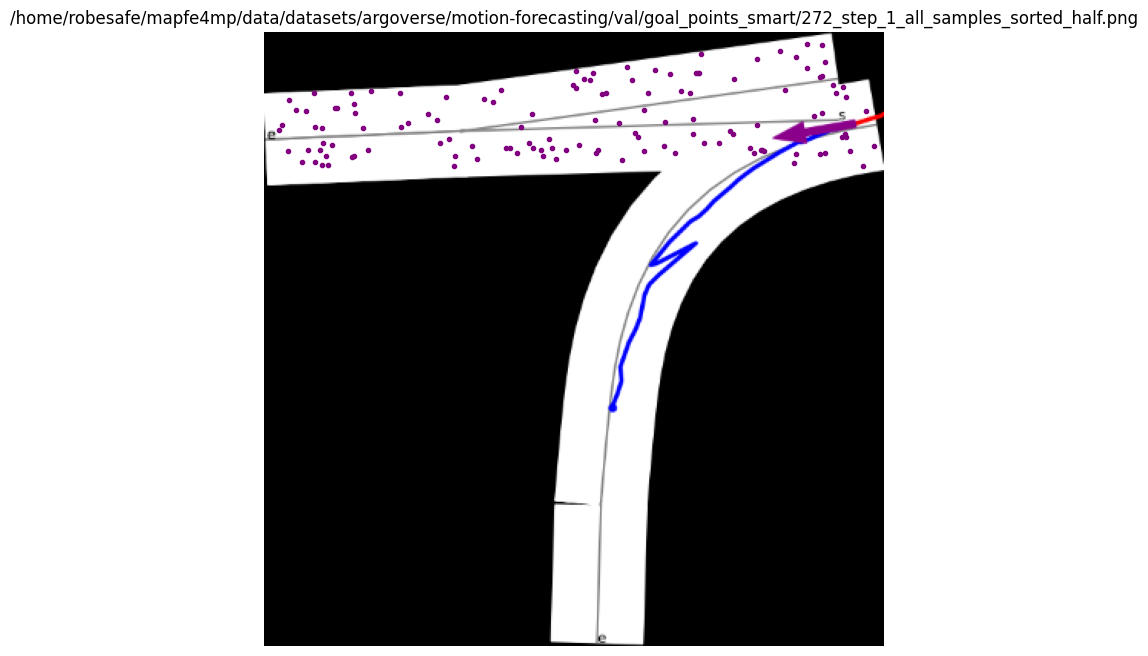

In [16]:
# Test if the points are ordered (from top-left to bottom-right) taking the upper half

filename = os.path.join(goal_points_folder,str(file_id) + "_step_1_all_samples_sorted_half.png")
goal_points_functions.plot_fepoints(img, filename, goals_px_x=fe_x[:int(num_initial_samples/2)], goals_px_y=fe_y[:int(num_initial_samples/2)],
                                    save_fig=save_fig, show=show, change_bg=change_img_bg)

center:  [ 575.64738062 1376.70850327]
Lims:  562.7614359887881 1363.9210904411925 588.5333252524214 1389.495916100284


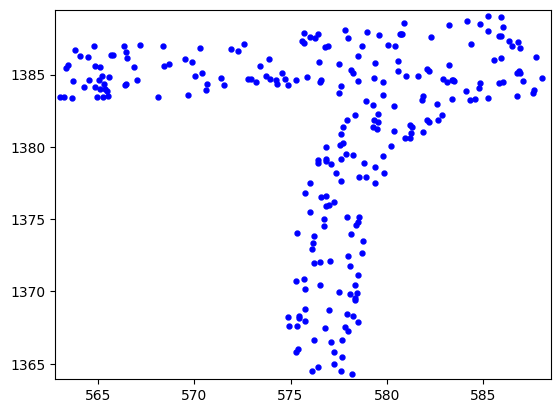

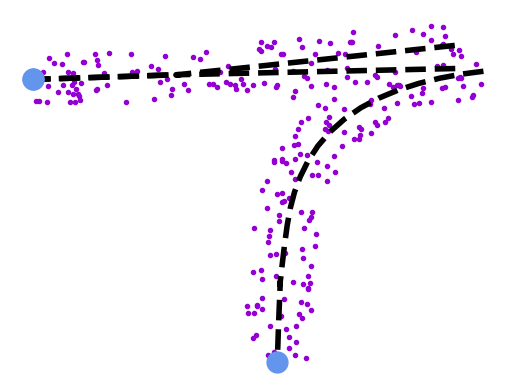

filename:  /home/robesafe/mapfe4mp/data/datasets/argoverse/motion-forecasting/val/goal_points_smart/272_plausible_area_and_centerlines.png


In [19]:
# 2. Transform the selected pixels to real-world points (global coordinates)

final_samples_px = np.hstack((fe_y.reshape(-1,1), fe_x.reshape(-1,1))) # rows (y), columns (x)
rw_points = goal_points_functions.transform_px2real_world(final_samples_px, 
                                                          center_plausible_area_filtered, 
                                                          (real_world_width,real_world_height), 
                                                          (rows,cols))

# 2.0.1. Plot points to ensure the plausible area has been correctly transformed

plt.scatter(rw_points[:,0], rw_points[:,1], c="blue", marker=".", s=50) # Points from the plausible area
# plt.axis("off")

x_min = center_plausible_area_filtered[0] - real_world_width/2
y_min = center_plausible_area_filtered[1] - real_world_height/2
x_max = center_plausible_area_filtered[0] + real_world_width/2
y_max = center_plausible_area_filtered[1] + real_world_height/2

print("center: ", center_plausible_area_filtered)
print("Lims: ", x_min, y_min, x_max, y_max)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()
plt.close('all')

# 2.1. Then, transform to absolute coordinates around the last observation of the target agent

abs_points = rw_points - last_obs

# 2.1.1. Plot to ensure this transformation

fig, ax = plt.subplots()
plt.scatter(abs_points[:,0], abs_points[:,1], c="darkviolet", marker=".", s=35) # Points from the plausible area
agent_xy_abs = agent_xy - last_obs
# plt.plot(agent_xy_abs[:obs_len,0], agent_xy_abs[:obs_len,1], "-", color="goldenrod", linewidth=5) # Agent's obs
# plt.plot(agent_xy_abs[obs_len:,0], agent_xy_abs[obs_len:,1], "-", color="indianred", linewidth=5) # Agent's gt

# last_gt = agent_xy[-1,:] - last_obs
# last_obs_patch = plt.Circle((0,0), 0.5, color='yellow',zorder=10)
# last_gt_patch = plt.Circle((last_gt[0],last_gt[1]), 0.5, color='green',zorder=10)
# ax.add_patch(last_obs_patch)
# ax.add_patch(last_gt_patch)

# 2.1.2. Plot the different centerlines

for centerline in relevant_centerlines_filtered:
    centerline = centerline - last_obs
    plt.plot(
            centerline[:, 0],
            centerline[:, 1],
            "--",
            color="black",
            alpha=1,
            linewidth=4,
            zorder=15,
            )

#     factor = 0.5
#     noise = factor * np.random.randn(centerline.shape[0],centerline.shape[1])
#     plausible_points = noise + centerline
#     plt.scatter(plausible_points[:,0], plausible_points[:,1], c="darkviolet", marker=".", s=30) # Points from the plausible area
    
    plt.plot(
            centerline[-1, 0],
            centerline[-1, 1],
            "o",
            color="cornflowerblue",
            alpha=1,
            markersize=15,
            zorder=20,
            )
plt.axis("off")
plt.show()
plt.cla()

filename = os.path.join(goal_points_folder,str(file_id) + "_plausible_area_and_centerlines.png")
print("filename: ", filename)              
fig.tight_layout(pad=0)
fig.canvas.draw()
img = cv2.cvtColor(np.asarray(fig.canvas.buffer_rgba()), cv2.COLOR_RGBA2BGR)
cv2.imwrite(filename, img)
                                
plt.close('all')